<a href="https://colab.research.google.com/github/IpsitaSenapati/CNN_DL_AI/blob/main/mnist_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import datasets

In [3]:
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from torchvision import transforms

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [7]:
from torchvision.utils import make_grid

In [8]:
import numpy as np
import pandas as pd

In [9]:
from tqdm import tqdm

In [10]:
mnist_train=datasets.MNIST(root="./datasets/" , train= True , download=True)
mnist_test=datasets.MNIST(root="./datasets/" , train= False , download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145660941.62it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31628118.49it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44185917.25it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5427501.07it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [11]:
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test)

In [12]:
num_classes= mnist_train.classes
num_classes[6]

'6 - six'

In [13]:
class_index=mnist_train.class_to_idx
class_index

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [14]:
img, label= mnist_train[7]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 3)

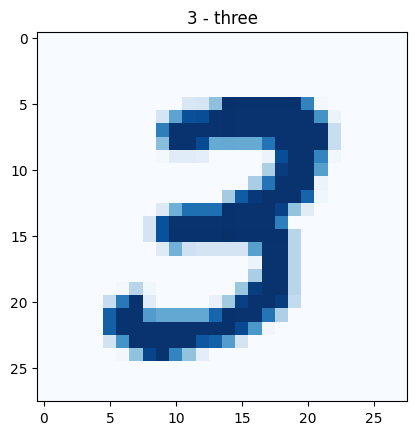

In [15]:
plt.imshow(img, cmap='Blues')
plt.title(f"{num_classes[label]}");

In [16]:
#normalisation  for mnist_dataset
trans=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]
)

In [17]:
mnist_train=datasets.MNIST(root="./datasets/" , train= True , download=True , transform=trans)
mnist_test=datasets.MNIST(root="./datasets/" , train= False , download=True , transform=trans)

In [18]:
img, label= mnist_train[7]
img, label

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 3)

In [19]:
def show(img,label):
  print('Label: ', label)
  plt.imshow(img.permute(1,2,0), cmap = 'Blues')

Label:  8


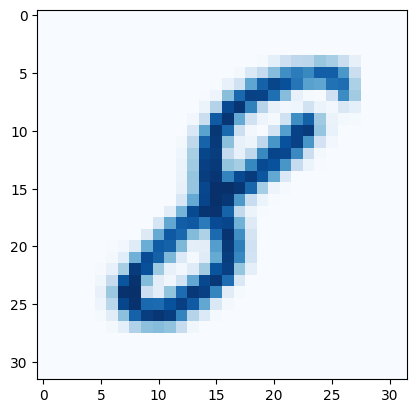

In [20]:
show(*mnist_train[7777])

In [21]:
#validation split function
def split_val(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]

In [22]:
#validation split of mnist_test data
val_per = 0.15
seed = 40
train_indices, val_indices = split_val(len(mnist_train), val_per, seed)
print(len(train_indices), len(val_indices))

51000 9000


In [23]:
batch_size = 1024

In [24]:
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(mnist_train, batch_size, sampler = train_sampler)

In [25]:
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(mnist_train, batch_size, sampler = val_sampler)

In [26]:
def show_set(dl):
  for img,label in dl:
    fig, ax=plt.subplots(figsize=(10,10))
    ax.imshow(make_grid(img[:100], 10).permute(1,2,0))
    break


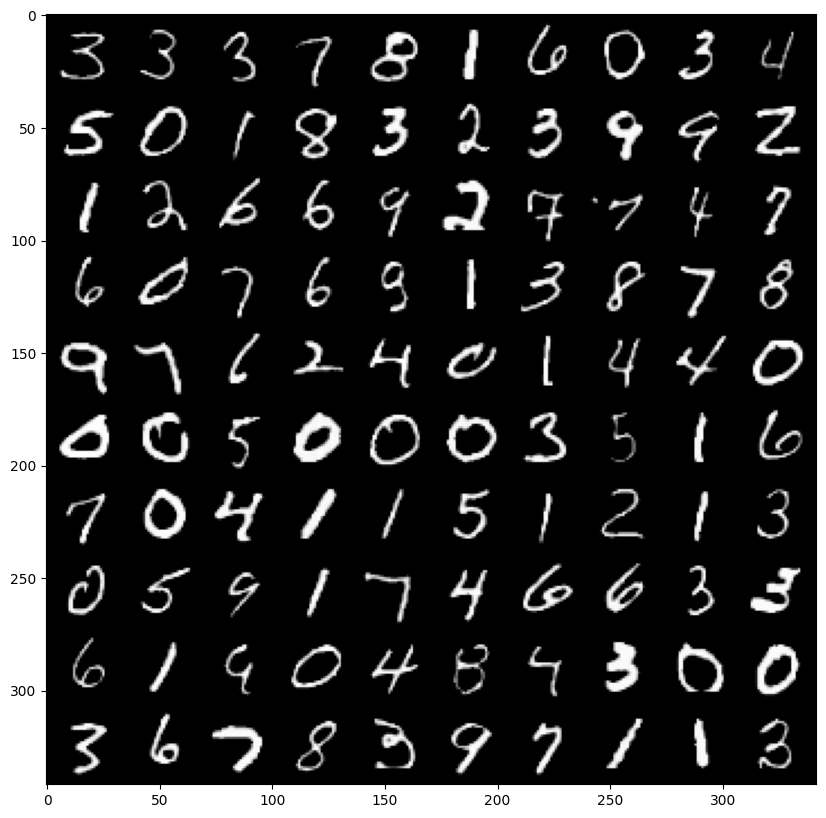

In [27]:
show_set(train_dl)

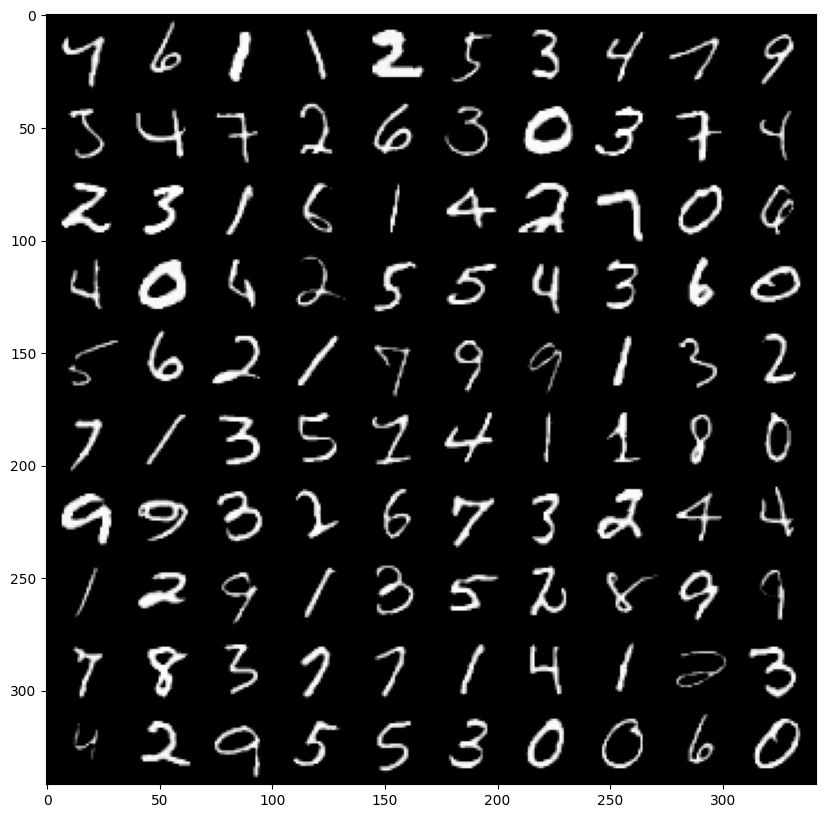

In [28]:
show_set(val_dl)

In [29]:
class LeNet5(nn.Module):

    def __init__(self, num_classes):

        super().__init__()

        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )



    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit
# Load Model

In [30]:
mnist_model=LeNet5(num_classes=10)

In [ ]:
mnist_model

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [31]:
for images, labels in train_dl:
    print('Image Shape', images.shape)
    out = mnist_model(images)
    print('output shape', out.shape)
    print('out[0]', out[0])
    break

Image Shape torch.Size([1024, 1, 32, 32])
output shape torch.Size([1024, 10])
out[0] tensor([ 0.0940,  0.0994, -0.0925, -0.0104,  0.1523,  0.1232,  0.1038,  0.0392,
         0.0198,  0.0192], grad_fn=<SelectBackward0>)


In [32]:
probs = F.softmax(out[0], dim = 0)
probs

tensor([0.1037, 0.1043, 0.0861, 0.0935, 0.1100, 0.1068, 0.1048, 0.0982, 0.0963,
        0.0963], grad_fn=<SoftmaxBackward0>)

In [33]:
m = torch.argmax(probs)
m

tensor(4)

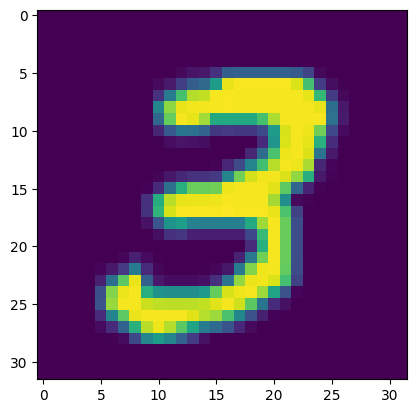

In [34]:
plt.imshow(img.permute(1,2,0))

In [35]:
def get_default_device():
     #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [36]:
#device available
device = get_default_device()
device

device(type='cpu')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(mnist_model, device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [38]:
#loss function
def loss_found(mnist_model, loss_func1 , x , y , opt=None , metric=None):
  pred=mnist_model(x)
  loss=loss_func1(pred , y)
  if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

  metric_result = None
  if metric is not None:
        metric_result = metric(pred, y)

  return loss.item(), len(x), metric_result


In [39]:
#mnist helper-fit
def evaluate(mnist_model, loss_fn, val_dl, metric = None):

    with torch.no_grad():

        results = [loss_found(mnist_model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None

        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [40]:
#mnist helper-fit
def fit(epochs, mnist_model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    train_losses, val_losses, val_metrics, train_metrics = [], [], [], []
    for epoch in range(epochs):
        mnist_model.train()
        for x, y in train_dl:
            train_loss, _, train_metric = loss_found(mnist_model, loss_fn, x, y, opt_fn, metric)

        mnist_model.eval()
        result = evaluate(mnist_model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        train_metrics.append(train_metric)

        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss))

        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}, train_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric, metric.__name__, train_metric))

        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])

    return train_losses, val_losses, val_metrics, train_metrics


In [41]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    return torch.sum(preds == labels).item() / len(preds)

In [42]:
val_loss, _, val_acc = evaluate(mnist_model, F.cross_entropy, val_dl, metric = accuracy)
print(val_loss, val_acc)

2.31155854288737 0.02988888888888889


In [43]:
#hyperparameters
num_epochs = 25
optimizer = torch.optim.SGD(mnist_model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

In [44]:
history = fit(num_epochs, mnist_model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/25, train_loss: 0.2678, val_loss: 0.2322, val_accuracy: 0.9331, train_accuracy: 0.9138
Epoch 2/25, train_loss: 0.1189, val_loss: 0.1085, val_accuracy: 0.9692, train_accuracy: 0.9612
Epoch 3/25, train_loss: 0.0612, val_loss: 0.0806, val_accuracy: 0.9773, train_accuracy: 0.9806
Epoch 4/25, train_loss: 0.0804, val_loss: 0.0671, val_accuracy: 0.9801, train_accuracy: 0.9745
Epoch 5/25, train_loss: 0.0642, val_loss: 0.0657, val_accuracy: 0.9796, train_accuracy: 0.9818
Epoch 6/25, train_loss: 0.0474, val_loss: 0.0573, val_accuracy: 0.9827, train_accuracy: 0.9842
Epoch 7/25, train_loss: 0.0412, val_loss: 0.0543, val_accuracy: 0.9841, train_accuracy: 0.9867
Epoch 8/25, train_loss: 0.0319, val_loss: 0.0531, val_accuracy: 0.9847, train_accuracy: 0.9915
Epoch 9/25, train_loss: 0.0307, val_loss: 0.0499, val_accuracy: 0.9852, train_accuracy: 0.9891
Epoch 10/25, train_loss: 0.0237, val_loss: 0.0449, val_accuracy: 0.9873, train_accuracy: 0.9915
Epoch 11/25, train_loss: 0.0224, val_loss: 0.0451

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

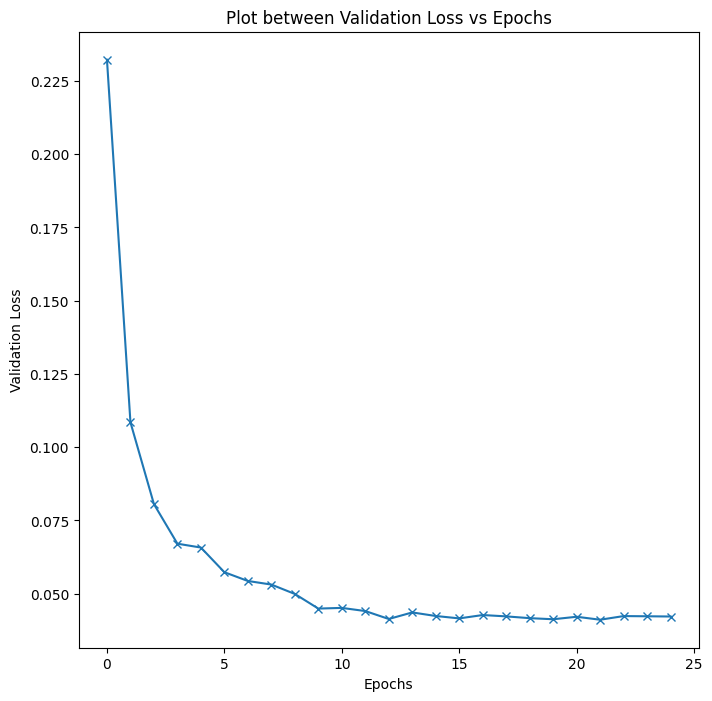

In [45]:
plt.figure(figsize = (8,8))
plt.plot(history[1], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')

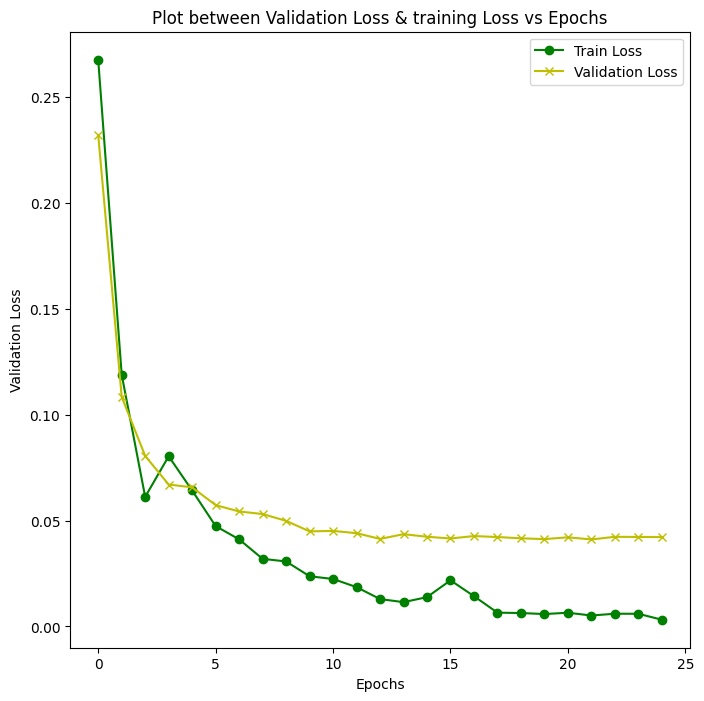

In [46]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-go')
plt.plot(history[1], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss & training Loss vs Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')

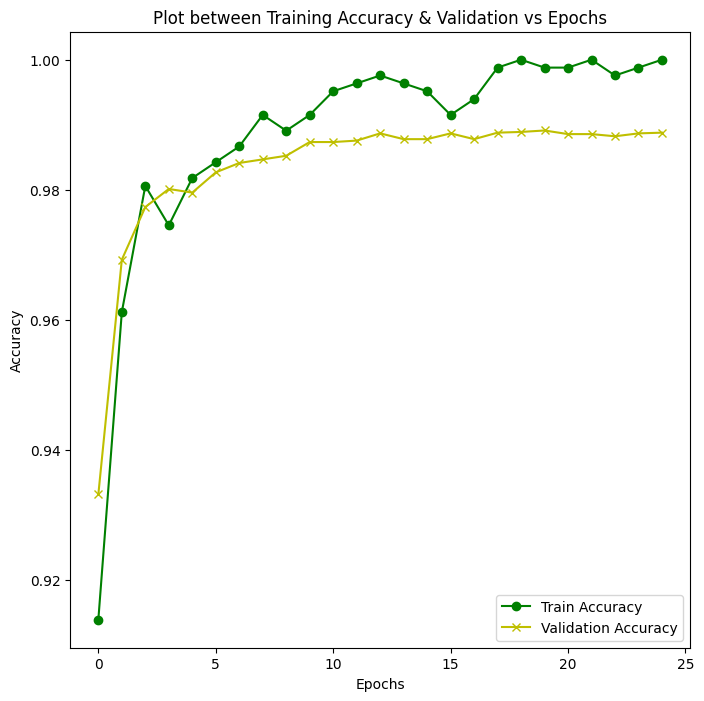

In [47]:
plt.figure(figsize = (8,8))
plt.plot(history[3], '-go')
plt.plot(history[2], '-yx')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot between Training Accuracy & Validation vs Epochs')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')

In [48]:
#prediction fn for mnist_model
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted: 1


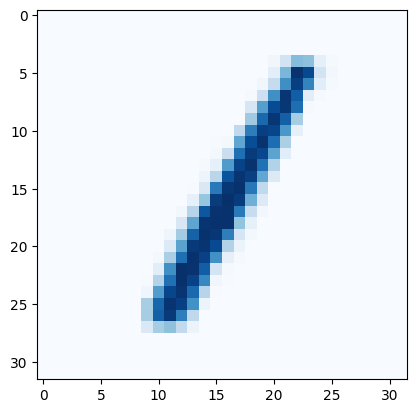

In [49]:
#making predictions
img, label = mnist_test[6789]
plt.imshow(img[0], cmap='Blues')
print('Label:', label, ', Predicted:', predict_image(img, mnist_model))

In [50]:
#testing the mnist_model
test_loader = DeviceDataLoader(DataLoader(mnist_test, batch_size=1024), device)
result = evaluate(mnist_model, F.cross_entropy, test_loader, metric = accuracy)
result
Accuracy = result[2] * 100
Accuracy
loss = result[0]
print("Total Losses: {}, Accuracy: {}".format(loss, Accuracy))

Total Losses: 0.03356790361404419, Accuracy: 98.87


In [51]:
#normalisation for cifar_dataset
transform_cifar = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [52]:
#cifar datasets
cifar_train=datasets.CIFAR10(root="./datasets/" , train= True , download=True , transform=transform_cifar)
cifar_test=datasets.CIFAR10(root="./datasets/" , train= False , download=True , transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 43508771.51it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets/
Files already downloaded and verified


In [53]:
cifar_train, cifar_test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=4, fill=0, padding_mode=constant)
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=None)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [54]:
img_classes= cifar_train.classes

In [55]:
img_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [57]:
#hyperparameters for cifar_model
c_epochs = 25
learning_rate = 0.001

In [58]:
#dividing the cifar training dataset
cifar_val_per = 0.15
c_seed = 40
c_train_indices, c_val_indices = split_val(len(cifar_train), cifar_val_per, c_seed)
print(len(c_train_indices), len(c_val_indices))

42500 7500


In [60]:
c_val_sampler = SubsetRandomSampler(c_val_indices)
c_val_dl = DataLoader(cifar_train, batch_size=100, sampler =c_val_sampler)

In [61]:
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                           batch_size=100,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=cifar_test,
                                          batch_size=100,
                                          shuffle=False)

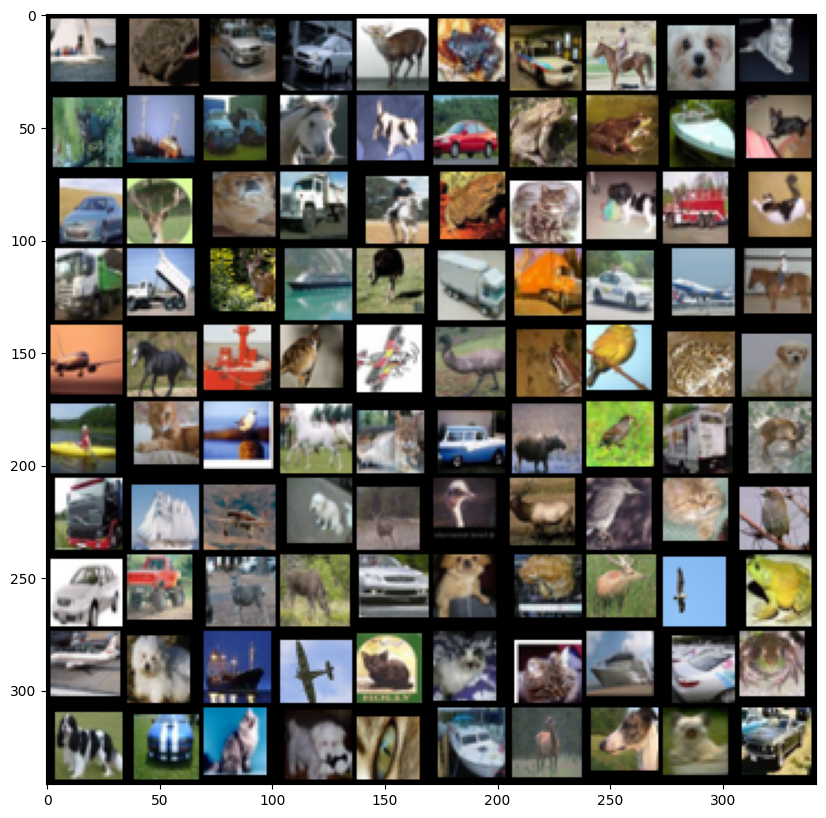

In [64]:
show_set(train_loader)

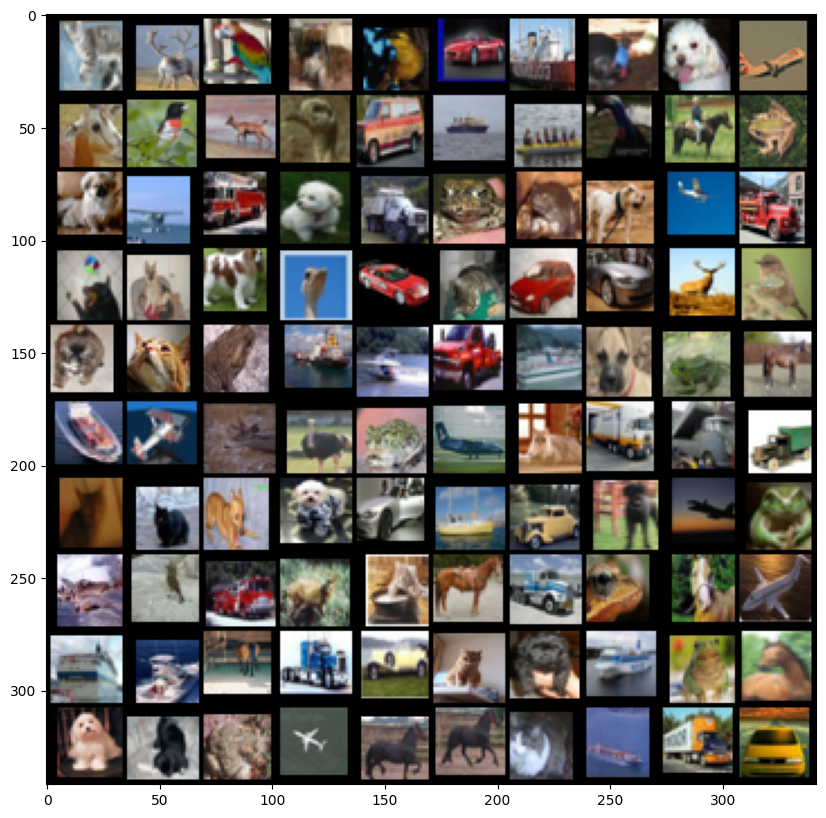

In [65]:
show_set(c_val_dl)

In [66]:
c_val_dl = DeviceDataLoader(c_val_dl, device)

In [67]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)

In [68]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [69]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [70]:
cifar_model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar_model.parameters(), lr=learning_rate)

In [77]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [76]:
#training the cifar_model
total_step = len(train_loader)
curr_lr = learning_rate
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
for epoch in range(c_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cifar_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, c_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/25], Step [100/200] Loss: 1.5254
Epoch [1/25], Step [200/200] Loss: 1.1884
Epoch [2/25], Step [100/200] Loss: 0.9325
Epoch [2/25], Step [200/200] Loss: 0.9905
Epoch [3/25], Step [100/200] Loss: 0.9745
Epoch [3/25], Step [200/200] Loss: 0.8968
Epoch [4/25], Step [100/200] Loss: 0.8828
Epoch [4/25], Step [200/200] Loss: 0.7838
Epoch [5/25], Step [100/200] Loss: 0.7325
Epoch [5/25], Step [200/200] Loss: 0.7615
Epoch [6/25], Step [100/200] Loss: 0.7051
Epoch [6/25], Step [200/200] Loss: 0.6566
Epoch [7/25], Step [100/200] Loss: 0.6570
Epoch [7/25], Step [200/200] Loss: 0.6503
Epoch [8/25], Step [100/200] Loss: 0.6714
Epoch [8/25], Step [200/200] Loss: 0.6223
Epoch [9/25], Step [100/200] Loss: 0.5215
Epoch [9/25], Step [200/200] Loss: 0.5174
Epoch [10/25], Step [100/200] Loss: 0.5126
Epoch [10/25], Step [200/200] Loss: 0.4911
Epoch [11/25], Step [100/200] Loss: 0.6189
Epoch [11/25], Step [200/200] Loss: 0.4055
Epoch [12/25], Step [100/200] Loss: 0.5971
Epoch [12/25], Step [200/200]

In [134]:
# validation accuracy for cifar_model
import random
if (i+1) % 2 == 0:
  cifar_model.eval()
  with torch.no_grad():
      correct_val = 0
      total_val = 0
      for images, labels in c_val_dl:
          images = images.to(device)
          labels = labels.to(device)
          outputs = cifar_model(images)
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()
          val_accuracy = 100 * correct_val / total_val
  print('Validation Accuracy: {:.2f}%'.format(val_accuracy))


Validation Accuracy: 90.87%


In [115]:
def predict_image(image, model, device):
    # Prepare the image for prediction
    image = image.to(device)  # Move the image to the same device as the model
    image = image.unsqueeze(0)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # Return the predicted class label
    return predicted.item()




In [92]:
#Making predictions using the test-datset
img, label = cifar_test[453]
predicted_class = predict_image(img, cifar_model, device)

In [93]:
predicted_class , label

(3, 3)

In [135]:
#testing the model
cifar_model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cifar_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
print('Accuracy of the model on the test images: {:.3f}%'.format(100 * correct_test / total_test))

Accuracy of the model on the test images: 86.190%
